In [1]:
using Plots
using LinearAlgebra

In [2]:
include("CompQM.jl") 

In [3]:
module My

Base.@kwdef struct Parameters
    ħc::Float64 = 197
    mc²::Float64 = 938 # rest energy of nucleon
    α::Float64 = 0.0072973525693 # fine-structure constant
    
    # Skyrme parameters
    t₀::Float64 = -1128.75
    t₁::Float64 = 395.0
    t₂::Float64 = -95.0
    t₃::Float64 = 14000.0
    W₀::Float64 = 120
    x₀::Float64 = 0.45
    α₃::Float64 = 1
    
    Z::Int64 # proton number
    N::Int64 # neutron number
    A::Int64 = Z+N # mass number
end

Base.@kwdef struct Densities
    # number density
    ρ₀::Array{Float64, 1}
    ρ₁::Array{Float64, 1}
    
    # kinetic density
    τ₀::Array{Float64, 1}
    τ₁::Array{Float64, 1}
    
    # spin-orbit current
    J₀::Array{Float64, 1}
    J₁::Array{Float64, 1}
    
    # coulomb potential
    ϕ::Array{Float64, 1}
end

Base.@kwdef struct QuantumNumbers
    l::Int64 # orbital angular momentum
    j::Int64 # total angular momentum multiplied by 2
    q::Int64 # isospin
end

Base.@kwdef struct SingleParticleState 
    E::Float64 # energy
    qnums::QuantumNumbers
    ψ::Array{Float64, 1} # radial wave function 
end

end

using .My

In [4]:
rs = range(1e-2, 30, length=1000)
qnums = My.QuantumNumbers(0, 1, 1)
pars = My.Parameters(Z=8, N=8, A=16)

Main.My.Parameters(197.0, 938.0, 0.0072973525693, -1128.75, 395.0, -95.0, 14000.0, 120.0, 0.45, 1.0, 8, 8, 16)

### initial potential
$$
    V = V_{\mathrm{WS}} + V_{\mathrm{LS}} 
    \\
    V_{\mathrm{WS}} = \frac{V_0}{1 + \exp\left(\frac{r-R}{a}\right)},\ \ \  
    V_0 = -51 + 33 \frac{Z-N}{A} \tau_3
    \\
    V_{\mathrm{LS}} 
    = - 0.44 r_0^2 \frac{1}{r} \frac{dV_{\mathrm{WS}}}{dr}
    = 0.44\frac{r_0^2}{ar} \frac{V_0 \exp\left(\frac{r-R}{a}\right)}{\left[1 + \exp\left(\frac{r-R}{a}\right)\right]^2}
$$

In [5]:
"""
    initialize_potential(pars, rs, qnums)

Initialize potential at lattice points as woods-saxon plus spin-orbit force.
"""
function initialize_potential(pars, rs, qnums)
    Z = pars.Z
    N = pars.N
    A = pars.A
    
    l = qnums.l
    j = qnums.j
    q = qnums.q
    
    a = 0.67 # surface fluctuation
    r₀ = 1.27
    R = r₀*A^(1/3) # nuclear radius
    
    v₀ = -51+ q*33(Z-N)/A 
    ls = (j*(j+2) - 4l*(l+1) - 3)/8
    
    vpot = zeros(Float64, length(rs))
    
    # woods-saxon
    @. vpot += v₀/(1 + exp((rs-R)/a)) 
    
    # spin-orbit force
    @. vpot += ls*(0.44r₀^2/(a*rs)) * v₀*exp((rs-R)/a)/(1 + exp((rs-R)/a))^2
    
    return vpot
end


"""
    initialize_meff(pars, rs)

Initialize effective mass m*(r)c² at lattice points such that m*(r)c² = mc².
"""
function initialize_meff(pars, rs)
    meff = zeros(Float64, length(rs))
    @. meff = pars.mc²
    return meff
end


"""
    calc_k²

Calculate k²(r) = -l(l+1)/r² + (2m*c²/ħc)(V(r) - E) at lattice points
"""
function calc_k²(pars, rs, vpot, meff, E, qnums)
    ħc = pars.ħc
    l = qnums.l
    
    k² = zeros(Float64, length(rs))
    @. k² = -l*(l+1)/rs^2 - (vpot - E)*2meff/ħc^2
    return k²
end

function test_initialize_potential(pars, rs, qnums)
    @time vpot = initialize_potential(pars, rs, qnums)
    @time meff = initialize_meff(pars, rs)
    
    E = -30
    @time k² = calc_k²(pars, rs, vpot, meff, E, qnums)
    
    plot(rs, vpot, label="potential")
    plot!(rs, k², label="k²", ylims=(-60, 10))
end

test_initialize_potential (generic function with 1 method)

  0.017598 seconds (29.04 k allocations: 1.310 MiB)
  0.000002 seconds (1 allocation: 7.938 KiB)
  0.000007 seconds (1 allocation: 7.938 KiB)


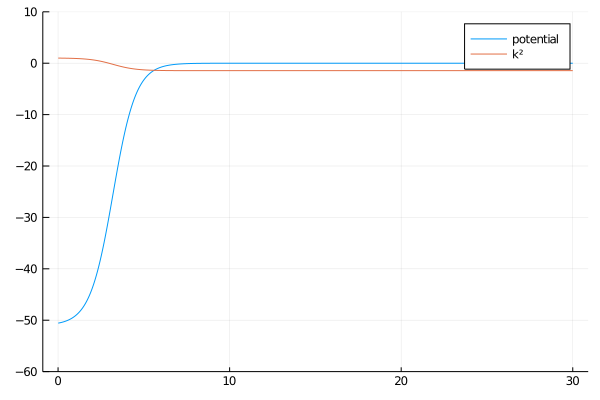

In [6]:
test_initialize_potential(pars, rs, qnums)

In [7]:
function solve_scheq(pars, rs, vpot, meff, E, qnums)
    A = pars.A
    l = qnums.l
    
    k² = calc_k²(pars, rs, vpot, meff, E, qnums)
    S = zeros(Float64, length(rs))
    
    # matching point
    h = rs[2]-rs[1]
    rc = 1.2A^(1/3)
    irc = floor(Int, (rc-rs[1])/h)
    
    # outward integration
    ψ_L = zeros(Float64, length(rs))
    @. ψ_L[1:2] = rs[1:2]^(l+1)
    for ir in 2:irc-1
        ψ_L[ir+1] = numerov(ir, rs, k², S, ψ_L[ir-1], ψ_L[ir])
    end
    
    # inward integration 
    ψ_R = zeros(Float64, length(rs))
    if k²[end] < 0
        κ = √(-k²[end])
        @. ψ_R[end-1:end] = exp(-κ*rs[end-1:end])
    else
        k = √(k²[end])
        @. ψ_R[end-1:end] = sin(k*(rs[end-1:end] - rs[end]))
    end
    for ir in length(rs)-1: -1: irc+1
        ψ_R[ir-1] = numerov(ir, rs, k², S, ψ_R[ir+1], ψ_R[ir]; sign=-1)
    end
    
    # normalize ψ_R so that ψ_L[irc] = ψ_R[irc]
    @. ψ_R *= ψ_L[irc]/ψ_R[irc]
    ψ = vcat(ψ_L[1:irc], ψ_R[irc+1:end])
    
    # normalize wave function
    norm = simps(rs, @. meff*ψ^2)
    ψ /= sqrt(norm)
    
    # calculate discontinuity at matching point
    discontinuity = ψ[irc-1] + ψ[irc+1] - (2 - h^2*k²[irc])*ψ[irc]
    discontinuity /= h
    
    @. ψ = sqrt(meff)*ψ
    
    return ψ, discontinuity
end

function calc_discontinuity(E, pars, rs, vpot, meff, qnums)
    ψ, discontinuity = solve_scheq(pars, rs, vpot, meff, E, qnums)
    return discontinuity
end
    
function test_solve_scheq(pars, rs, qnums)
    vpot = initialize_potential(pars, rs, qnums)
    meff = initialize_meff(pars, rs)
    
    @time E = bisect(calc_discontinuity, -35, -25, args=(pars, rs, vpot, meff, qnums,))
    @time ψ, discontinuity = solve_scheq(pars, rs, vpot, meff, E, qnums)
    
    @show E discontinuity
    plot(rs, ψ)
end

test_solve_scheq (generic function with 1 method)

  0.075656 seconds (36.70 k allocations: 5.921 MiB)
  0.000044 seconds (10 allocations: 63.656 KiB)
E = -31.108539341948926
discontinuity = -6.665448036794459e-12


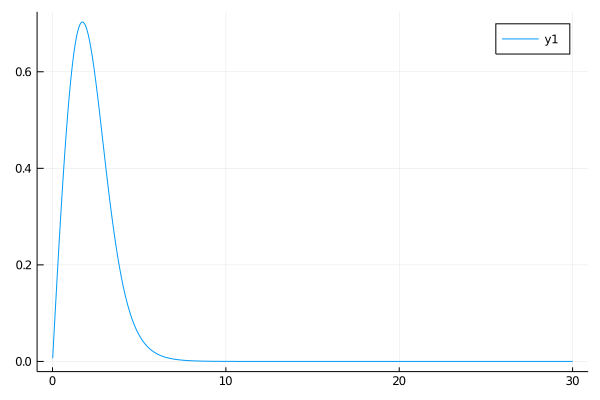

In [8]:
test_solve_scheq(pars, rs, qnums)

In [40]:
"""
    shooting_subspace(pars, rs, vpot, meff, Es, qnums)

find energy eigenvalue by shooting method.
"""
function shooting_subspace(pars, rs, vpot, meff, Es, qnums)
    states = My.SingleParticleState[]
    
    for i in 1:length(Es)-1
        d1 = calc_discontinuity(Es[i], pars, rs, vpot, meff, qnums)
        d2 = calc_discontinuity(Es[i+1], pars, rs, vpot, meff, qnums)
        
        if d1*d2 < 0
            E = bisect(calc_discontinuity, Es[i], Es[i+1], args=(pars, rs, vpot, meff, qnums,))
            if abs(calc_discontinuity(E, pars, rs, vpot, meff, qnums)) > 1e-5
                continue
            end
            ψ, discontinuity = solve_scheq(pars, rs, vpot, meff, E, qnums)
            push!(states, My.SingleParticleState(E=E, qnums=qnums, ψ=ψ))
        end
        
    end
    
    return states
end


"""
    sort_states(states)

Sort states::Array{SingleParticleStates, 1} such that states[i].E ≤ states[j].E for i < j
"""
function sort_states(states)
    n_states = length(states)
    for i in 1:n_states-1
        for j in i+1:n_states
            if states[i].E > states[j].E
                temp = states[i]
                states[i] = states[j]
                states[j] = temp
            end
        end
    end
    return states
end


"""
    calc_occ(pars, states)

calculate occupation number .
"""
function calc_occ(pars, states)
    Z = pars.Z
    N = pars.N
    occ = zeros(Float64, length(states))
    
    # calculate occupation number 
    n_prot = 0
    n_neut = 0
    for i in 1:length(states)
        j = states[i].qnums.j
        q = states[i].qnums.q
        if q == 1 # proton
            if n_prot + (j+1) ≤ Z
                occ[i] = 1
                n_prot += (j+1)
            elseif n_prot < Z
                occ[i] = (Z - n_prot)/(j+1)
                n_prot = Z
            end
        elseif q == -1 # neutron
            if n_neut + (j+1) ≤ N
                occ[i] = 1
                n_neut += (j+1)
            elseif n_neut < N
                occ[i] = (N - n_neut)/(j+1)
                n_neut = N
            end
        end
    end
    @assert n_prot == Z && n_neut == N
    
    return occ
end

"""
    calc_density(pars, rs, meff, states, occ)

calculate number density, kinetic density and spin-orbit current.
"""
function calc_density(pars, rs, states, occ)
    n_grids = length(rs)
    n_states = length(states)
    
    temp = zeros(Float64, n_grids)
    ρ₀ = zeros(Float64, n_grids)
    ρ₁ = zeros(Float64, n_grids)
    τ₀ = zeros(Float64, n_grids)
    τ₁ = zeros(Float64, n_grids)
    J₀ = zeros(Float64, n_grids)
    J₁ = zeros(Float64, n_grids)
    
    for i in 1:n_states
        l = states[i].qnums.l
        j = states[i].qnums.j
        q = states[i].qnums.q
        
        ψ = states[i].ψ
        dψ = diff(rs, ψ)
        
        # number density
        @. temp = occ[i] * (j+1)/4π * (ψ/rs)^2
        @. ρ₀ += temp
        @. ρ₁ += q*temp
        
        # kinetic density
        @. temp = occ[i] * (j+1)/4π * ( (dψ/rs - ψ/rs^2)^2 + l*(l+1)*(ψ/rs^2)^2 )
        @. τ₀ += temp
        @. τ₁ += q*temp
        
        # spin-orbit current
        ls = (j*(j+2) - 4l*(l+1) - 3)/8
        @. temp = occ[i] * (j+1)/2π * ls/rs * (ψ/rs)^2
        @. J₀ += temp
        @. J₁ += q*temp
    end
    
    # coulomb potential
    ϕ = solve_poisson(pars.Z, rs, @. (ρ₀ + ρ₁)/2)
    
    dens = My.Densities(ρ₀=ρ₀, ρ₁=ρ₁, τ₀=τ₀, τ₁=τ₁, J₀=J₀, J₁=J₁, ϕ=ϕ)
    return dens
end


"""
    calc_meff(pars, rs, dens)

Calculate effective mass from densities.
"""
function calc_meff(pars, rs, dens, qnums)
    ħc = pars.ħc
    mc² = pars.mc²
    t₁ = pars.t₁
    t₂ = pars.t₂
    
    ρ₀ = dens.ρ₀
    ρ₁ = dens.ρ₁
    
    q = qnums.q
    
    meff = zeros(Float64, length(rs))
    @. meff = 1/mc² + (1/8ħc^2)*( (3t₁ + 5t₂)*ρ₀ + (t₂ - t₁)*q*ρ₁ )
    @. meff = 1/meff
    return meff
end


"""
    calc_vpot(pars, rs, dens, meff, qnums)

Calculate hartree-fock potential from densities.
"""
function calc_vpot(pars, rs, dens, qnums)
    ħc = pars.ħc
    α = pars.α 
    t₀ = pars.t₀
    t₁ = pars.t₁
    t₂ = pars.t₂
    t₃ = pars.t₃
    W₀ = pars.W₀
    x₀ = pars.x₀
    α₃ = pars.α₃
    
    l = qnums.l
    j = qnums.j
    q = qnums.q
    ls = (j*(j+2) - 4l*(l+1) - 3)/8 
    
    ρ₀ = dens.ρ₀
    ρ₁ = dens.ρ₁
    τ₀ = dens.τ₀
    τ₁ = dens.τ₁
    J₀ = dens.J₀
    J₁ = dens.J₁
    ϕ = dens.ϕ
    
    vpot = zeros(Float64, length(rs))
    
    # t₀ term
    @. vpot += t₀*((3/4)*ρ₀ - q*(1/4 + x₀/2)*ρ₁)
    
    # t₃ term
    @. vpot += (t₃/16)*((α₃+2)*ρ₀^(α₃+1) - α₃*ρ₀^(α₃-1)*ρ₁^2 - 2q*ρ₀^α₃*ρ₁)
    #@. vpot += (t₃/12)*((3/4)*(α₃+2)*ρ₀^(α₃+1) - α₃/4*ρ₀^(α₃-1)*ρ₁^2 - 
        (1/2)*q*ρ₀^α₃*ρ₁)
    
    # ρτ term
    @. vpot += (1/16)*(3t₁ + 5t₂)*τ₀ + (1/16)*(t₂ - t₁)*q*τ₁
    
    # ρ∇²ρ term
    ddρ₀ = diff(rs, ρ₀; order=2)
    ddρ₁ = diff(rs, ρ₁; order=2)
    @. vpot += (1/32)*(5t₂ - 9t₁)*ddρ₀ + (1/32)*(3t₁ + t₂)*q*ddρ₁
    
    # J² term
    @. vpot += (1/8)*(t₁ - t₂)*(J₀ + q*J₁)*(ls/rs)
    
    # W₀ term
    dρ₀ = diff(rs, ρ₀)
    dρ₁ = diff(rs, ρ₁)
    dJ₀ = diff(rs, J₀)
    dJ₁ = diff(rs, J₁)
    @. vpot += -(3W₀/4)*(dJ₀ - (2/rs)*dρ₀*ls) - (W₀/4)*q*(dJ₁ - (2/rs)*dρ₁*ls)
    
    # coulomb direct term 
    @. vpot += (1/2)*(1+q)*ħc*α*ϕ 
    
    # coulomb exchange term
    @. vpot += -(1/2)*(1+q)*ħc*α*(3/π*(ρ₀+ρ₁)/2)^(1/3)
    
    # effective mass term
    meff = calc_meff(pars, rs, dens, qnums)
    dmeff = diff(rs, meff)
    ddmeff = diff(rs, meff; order=2)
    @. vpot += ħc^2/2meff * ( (5/4)*(dmeff/meff)^2 - ddmeff/meff )
    
    return vpot
end


"""
    calc_energy(pars, rs, dens)

Calculate total energy from densities.
"""
function calc_energy(pars, rs, dens)
    ħc = pars.ħc
    mc² = pars.mc²
    α = pars.α 
    t₀ = pars.t₀
    t₁ = pars.t₁
    t₂ = pars.t₂
    t₃ = pars.t₃
    W₀ = pars.W₀
    x₀ = pars.x₀
    α₃ = pars.α₃
    
    ρ₀ = dens.ρ₀
    ρ₁ = dens.ρ₁
    τ₀ = dens.τ₀
    τ₁ = dens.τ₁
    J₀ = dens.J₀
    J₁ = dens.J₁
    ϕ = dens.ϕ
    
    # energy density
    H = zeros(Float64, length(rs))
    
    # kinetic energy
    @. H += (ħc^2/2mc²)*τ₀
    
    # t₀ term
    @. H += t₀*( (3/8)*ρ₀^2 - (1/4)*(1/2 + x₀)*ρ₁^2 )
    
    # t₃ term
    @. H += (t₃/16)*(ρ₀^(α₃+2) - ρ₀^α₃*ρ₁^2)
    #@. H += (t₃/12)*ρ₀^α₃*((3/4)*ρ₀^2 - (1/2)*(1/2)*ρ₁^2)
    
    # ρτ term
    @. H += (1/16)*(3t₁ + 5t₂)*ρ₀*τ₀ + (1/16)*(t₂ - t₁)*ρ₁*τ₁
    
    # ρ∇²ρ term
    ddρ₀ = diff(rs, ρ₀; order=2)
    ddρ₁ = diff(rs, ρ₁; order=2)
    @. H += (1/64)*(5t₂ - 9t₁)*ρ₀*ddρ₀ + (1/64)*(3t₁ + t₂)*ρ₁*ddρ₁
    
    # J² term 
    @. H += (1/32)*(t₁ - t₂)*(J₀^2 + J₁^2)
    
    # W₀ term
    dJ₀ = diff(rs, J₀)
    dJ₁ = diff(rs, J₁)
    @. H += -(3/4)*W₀*ρ₀*dJ₀ - (1/4)*W₀*ρ₁*dJ₁
    
    # coulomb direct term
    @. H += (ħc*α/2)*(ρ₀ + ρ₁)/2*ϕ 
    
    # coulomb exchange term
    @. H += - (3ħc*α/4)*(3/π)^(1/3)*((ρ₀ + ρ₁)/2)^(4/3)
    
    E = simps(rs, @. 4π*rs^2*H)
    return E
end

    
    
function test_shooting_subspace(pars, rs, lmax)
    meff = initialize_meff(pars, rs)
    Es = range(-50, 1e-2, length=20)
    
    states = My.SingleParticleState[]
    for l in 0:lmax
        for j in 2l+1: -2:max(2l-1,0)
            for q in 1: -2: -1
                qnums = My.QuantumNumbers(l=l, j=j, q=q)
                vpot = initialize_potential(pars, rs, qnums)
                states = vcat(states, shooting_subspace(pars, rs, vpot, meff, Es, qnums))
            end
        end
    end
    states = sort_states(states)
    occ = calc_occ(pars, states)
    dens = calc_density(pars, rs, states, occ)
    
    qnums = My.QuantumNumbers(l=0, j=1, q=1)
    meff = calc_meff(pars, rs, dens, qnums)
    vpot = calc_vpot(pars, rs, dens, qnums)
    
    @show calc_energy(pars, rs, dens)/pars.A
    println("")
    
    p_states = plot()
    for i in 1:length(states)
        println("i = $i")
        @show states[i].E states[i].qnums occ[i]
        println("")
        plot!(p_states, rs, states[i].ψ)
    end
    
    p_dens = plot()
    plot!(p_dens, rs, vpot, label="vpot")
    return p_states, p_dens
end

LoadError: syntax: extra token ")" after end of expression

calc_energy(pars, rs, dens) / pars.A = -9.187264888228754

i = 1
(states[i]).E = -45.216565171912016
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 1.0

i = 2
(states[i]).E = -36.322247875965154
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, 1)
occ[i] = 1.0

i = 3
(states[i]).E = -35.02974830320594
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, -1)
occ[i] = 1.0

i = 4
(states[i]).E = -33.98592378349238
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)
occ[i] = 1.0

i = 5
(states[i]).E = -26.740106794233185
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, -1)
occ[i] = 1.0

i = 6
(states[i]).E = -26.686865671130974
(states[i]).qnums = Main.My.QuantumNumbers(2, 5, 1)
occ[i] = 1.0

i = 7
(states[i]).E = -24.727500312798902
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, -1)
occ[i] = 1.0

i = 8
(states[i]).E = -22.4895863234764
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 1.0

i = 9
(states[i]).E = -21.718864121965716
(states[i]).qnums = Main.My.QuantumN

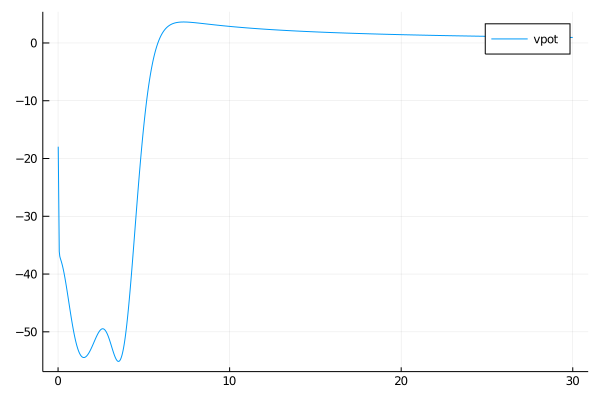

In [10]:
Z=20
N=28
pars = My.Parameters(Z=Z, N=N, A=Z+N)
lmax = 5
p_states, p_dens = test_shooting_subspace(pars, rs, lmax)
p_dens

In [21]:
"""
    average_density(rs, d₁, d₂)

Average two densities d₁ and d₂.
"""
function average_density(rs, d₁, d₂)
    n_grids = length(rs)
    
    ρ₀ = zeros(Float64, n_grids)
    ρ₁ = zeros(Float64, n_grids)
    τ₀ = zeros(Float64, n_grids)
    τ₁ = zeros(Float64, n_grids)
    J₀ = zeros(Float64, n_grids)
    J₁ = zeros(Float64, n_grids)
    ϕ = zeros(Float64, n_grids)
    
    @. ρ₀ = (d₁.ρ₀ + d₂.ρ₀)/2   
    @. ρ₁ = (d₁.ρ₁ + d₂.ρ₁)/2   
    @. τ₀ = (d₁.τ₀ + d₂.τ₀)/2   
    @. τ₁ = (d₁.τ₁ + d₂.τ₁)/2   
    @. J₀ = (d₁.J₀ + d₂.J₀)/2   
    @. J₁ = (d₁.J₁ + d₂.J₁)/2   
    @. ϕ = (d₁.ϕ + d₂.ϕ)/2
    
    d = My.Densities(ρ₀=ρ₀, ρ₁=ρ₁, τ₀=τ₀, τ₁=τ₁, J₀=J₀, J₁=J₁, ϕ=ϕ)
    return d
end


"""
    calc_rmsr(rs, ρ)

Calculate root mean square radius of density ρ
"""
function calc_rmsr(rs, ρ)
    rmsr = simps(rs, (@. rs^4*ρ))/simps(rs, (@. rs^2*ρ))
    rmsr = sqrt(rmsr)
end


"""
    DFT_calc(pars, rs, Es, lmax; iter_max=100, rtol=1e-5)

do DFT calculation.
"""
function DFT_calc(pars, rs, Es, lmax; iter_max=20, rtol=1e-5)
    meff = initialize_meff(pars, rs)
    BEperA = Float64[]
    
    # iter = 1
    states = My.SingleParticleState[]
    for l in 0:lmax
        for j in 2l+1: -2:max(2l-1,0)
            for q in 1: -2: -1
                qnums = My.QuantumNumbers(l, j, q)
                vpot = initialize_potential(pars, rs, qnums)
                states = vcat(states, shooting_subspace(pars, rs, vpot, meff, Es, qnums))
            end
        end
    end
    states = sort_states(states)
    occ = calc_occ(pars, states)
    
    dens = calc_density(pars, rs, states, occ)
    
    push!(BEperA, -calc_energy(pars, rs, dens)/pars.A)
    
    
    # iter ≥ 2
    for iter in 2:iter_max
        states = My.SingleParticleState[]
        
        for l in 0:lmax
            for j in 2l+1: -2:max(2l-1,0)
                for q in 1: -2: -1
                    qnums = My.QuantumNumbers(l, j, q)
                    
                    meff = calc_meff(pars, rs, dens, qnums)
                    vpot = calc_vpot(pars, rs, dens, qnums)
                    states = vcat(states, shooting_subspace(pars, rs, vpot, meff, Es, qnums))
                end
            end
        end
        states = sort_states(states)
        occ = calc_occ(pars, states)
        
        dens_new = calc_density(pars, rs, states, occ)
        dens = average_density(rs, dens, dens_new)
        
        push!(BEperA, -calc_energy(pars, rs, dens)/pars.A)
        
        if abs((BEperA[end] - BEperA[end-1])/BEperA[end]) < rtol
            println("iteration converged at iter = $iter")
            return states, occ, dens, BEperA
        end
    end
    error("no convergence!")
end

DFT_calc

In [42]:
Z = 8
N = 8
pars = My.Parameters(Z=Z, N=N)

pars₀ = My.Parameters(
    Z=Z, 
    N=N, 
    α = 0, 
    t₀ = -1800, 
    t₁ = 0,
    t₂ = 0,
    t₃ = 12871,
    W₀ = 0,
    x₀ = 0,
    α₃ = 1/3)

rs = range(1e-3, 20, length=200)
Es = range(-50, -1e-2, length=20)
lmax = 7

@time states, occ, dens, BEperA = DFT_calc(pars, rs, Es, lmax)
rmsr = calc_rmsr(rs, dens.ρ₀)
;

iteration converged at iter = 15
  0.330188 seconds (371.85 k allocations: 389.130 MiB, 13.97% gc time)


BE/A = 9.43525590929907 MeV
rmsr = 2.5979136128040823 fm

i = 1
(states[i]).E = -38.416441023213
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, -1)
occ[i] = 1.0

i = 2
(states[i]).E = -34.85734867089673
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 1.0

i = 3
(states[i]).E = -24.277529650090354
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, -1)
occ[i] = 1.0

i = 4
(states[i]).E = -20.83458488752649
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, 1)
occ[i] = 1.0

i = 5
(states[i]).E = -18.678407383056015
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, -1)
occ[i] = 1.0

i = 6
(states[i]).E = -15.286647794822866
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)
occ[i] = 1.0

i = 7
(states[i]).E = -9.444257090033497
(states[i]).qnums = Main.My.QuantumNumbers(2, 5, -1)
occ[i] = 0.0

i = 8
(states[i]).E = -6.1593032269991035
(states[i]).qnums = Main.My.QuantumNumbers(2, 5, 1)
occ[i] = 0.0

i = 9
(states[i]).E = -2.793726840638954
(states[i]).qnums = Main.My.QuantumNumb

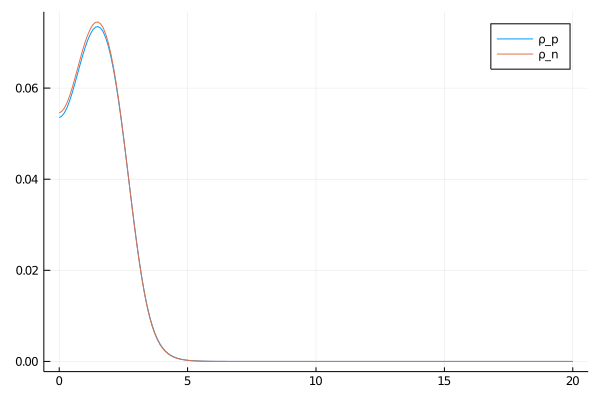

In [44]:
println("BE/A = $(BEperA[end]) MeV")
println("rmsr = $rmsr fm")
println("")

if true
    for i in 1:length(states)
        println("i = $i")
        @show states[i].E states[i].qnums occ[i]
        println("")
    end
end

plot(rs, (@. (dens.ρ₀+dens.ρ₁)/2), label="ρ_p")
plot!(rs, (@. (dens.ρ₀-dens.ρ₁)/2), label="ρ_n")

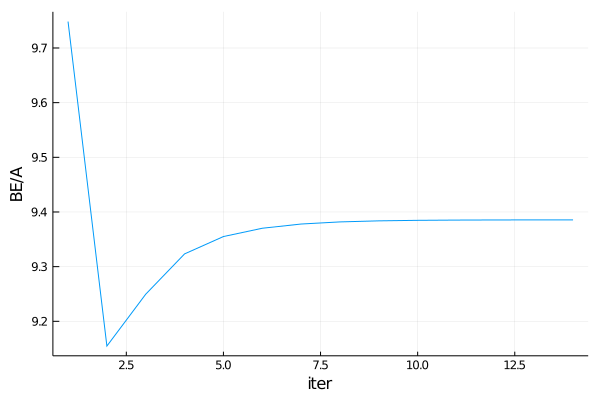

In [37]:
plot(BEperA, xlabel="iter", ylabel="BE/A", legend=false)